# House price prediction model search

Loop and grid search for the optimal house price model.

In [2]:
import geopandas as gpd
import numpy as np
import pandas as pd

import contextily
import palettable.matplotlib as palmpl
import matplotlib.pyplot as plt
import mapclassify
import libpysal

from utils import legendgram

from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_predict, GridSearchCV

In [1]:
data_folder = "/Users/martin/Library/CloudStorage/OneDrive-SharedLibraries-TheAlanTuringInstitute/Daniel Arribas-Bel - demoland_data"

Load the data

In [4]:
data = gpd.read_parquet(f"{data_folder}/processed/interpolated/all_oa.parquet")

Filter only explanatory variables.

In [5]:
exvars = data.drop(
    columns=[
        "geo_code",
        "geometry",
        "air_quality_index",
        "house_price_index",
        "jobs_accessibility_index",
        "greenspace_accessibility_index",
    ]
)

Specify grid search parameters. We can limit the options based on previous exploration.

In [6]:
parameters = {"learning_rate": (0.05, 0.1), "max_iter": [500], "max_bins": (64, 128)}

Define the simple weights matrices.

In [7]:
queen = libpysal.weights.Queen.from_dataframe(data)
weights = {
    "queen": queen,
    "queen2": libpysal.weights.higher_order(queen, k=2, lower_order=True),
    "queen3": libpysal.weights.higher_order(queen, k=3, lower_order=True),
    "queen4": libpysal.weights.higher_order(queen, k=4, lower_order=True),
    "queen5": libpysal.weights.higher_order(queen, k=5, lower_order=True),
    "500m": libpysal.weights.DistanceBand.from_dataframe(data, 500),
    "1000m": libpysal.weights.DistanceBand.from_dataframe(data, 1000),
    "2000m": libpysal.weights.DistanceBand.from_dataframe(data, 2000),
}

/Users/martin/mambaforge/envs/demoland/lib/python3.11/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  warnings.warn(message)
/Users/martin/mambaforge/envs/demoland/lib/python3.11/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 110 disconnected components.
 There are 82 islands with ids: 47, 71, 72, 89, 263, 361, 364, 375, 376, 377, 378, 541, 642, 983, 993, 1092, 1220, 1295, 1339, 1343, 1345, 1383, 1406, 1640, 1756, 1772, 1809, 1851, 1944, 1958, 2124, 2148, 2181, 2182, 2188, 2195, 2214, 2222, 2223, 2237, 2265, 2277, 2281, 2283, 2307, 2361, 2485, 2493, 2594, 2686, 2766, 2809, 2825, 2868, 2940, 2980, 3091, 3094, 3112, 3146, 3191, 3197, 3207, 3223, 3235, 3276, 3397, 3400, 3415, 3419, 3423, 3427, 3451, 3475, 3488, 3528, 3555, 3577, 3707, 3723, 3743, 3778.
  warnings.warn(message)
/Users/martin/mambaforge/envs/demoland/lib/python3.

Add combined weights on top.

In [8]:
weights["queen500m"] = libpysal.weights.w_union(weights["queen"], weights["500m"])
weights["queen1000m"] = libpysal.weights.w_union(weights["queen"], weights["1000m"])
weights["queen2000m"] = libpysal.weights.w_union(weights["queen"], weights["2000m"])

Get a mask to ignore missing values.

In [9]:
mask = data.house_price_index.notna()

Use Grid Search CV to find the best model for each weights option.

In [11]:
meta = {}
for name, W in weights.items():
    W.transform = "r"
    exvars = data.drop(
        columns=[
            "geo_code",
            "geometry",
            "air_quality_index",
            "house_price_index",
            "jobs_accessibility_index",
            "greenspace_accessibility_index",
        ]
    )
    for col in exvars.columns.copy():
        exvars[f"{col}_lag"] = libpysal.weights.spatial_lag.lag_spatial(W, exvars[col])
    regressor_lag = HistGradientBoostingRegressor(
        random_state=0,
    )
    est_lag = GridSearchCV(regressor_lag, parameters, verbose=1)
    est_lag.fit(exvars[mask], data.house_price_index[mask])
    meta[name] = {"score": est_lag.best_score_}
    y_pred_lag = cross_val_predict(
        est_lag.best_estimator_, exvars[mask], data.house_price_index[mask], cv=5
    )
    pred_lag = pd.Series(y_pred_lag, index=data.index[mask])
    residuals_lag = data.house_price_index[mask] - pred_lag
    meta[name]["mse"] = mean_squared_error(data.house_price_index[mask], pred_lag)
    meta[name]["me"] = residuals_lag.abs().mean()
    meta[name]["prediction"] = pred_lag
    meta[name]["residuals"] = residuals_lag
    meta[name]["model"] = est_lag.best_estimator_

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
('WARNING: ', 47, ' is an island (no neighbors)')
('WARNING: ', 71, ' is an island (no neighbors)')
('WARNING: ', 72, ' is an island (no neighbors)')
('WARNING: ', 89, ' is an island (no neighbors)')
('WARNING: ', 263, ' is an island (no neighbors)')
('WARNING: ', 361, ' is an island (no neighbors)')
('WARNING: ', 364, ' is an island (no neighbors)')
('WARNING: ', 375, ' is an island (no neighbors)')
('WARNING: ', 376, ' is an island (no neighbors)')
('WARNING: ', 377, ' is an island (no neighbors)')
('WARNING: ', 378, ' is an island (no neighbors)')
('WARNING: ', 541, ' is an island (no neighbors)')
('WARNING: ', 642, ' is an island (no neighbors)')
('WARNING: ', 983, ' is an island (no nei

Save evaluation metrics as series.

In [12]:
mse = pd.Series([vals["mse"] for vals in meta.values()], index=meta.keys())
me = pd.Series([vals["me"] for vals in meta.values()], index=meta.keys())
score = pd.Series([vals["score"] for vals in meta.values()], index=meta.keys())

Sort according to MSE. Lower is better.

In [13]:
mse.sort_values()

queen5        160164.675606
2000m         160245.606116
queen2000m    160766.019742
1000m         164343.481698
queen1000m    165435.671928
queen4        167802.714113
queen3        170864.677687
queen2        177496.106149
queen500m     185800.082368
500m          186592.783587
queen         201453.657786
dtype: float64

Sort according to ME. Lower is better.

In [14]:
me.sort_values()

2000m         304.115638
queen2000m    305.246902
queen5        306.013012
1000m         310.392479
queen4        311.826728
queen1000m    312.101787
queen3        317.151294
queen2        324.171353
queen500m     330.578553
500m          332.239067
queen         345.019843
dtype: float64

Sort according to R2. Higher is better.

In [15]:
score.sort_values()

queen         0.385277
500m          0.431761
queen500m     0.433833
queen2        0.454928
queen3        0.468809
queen4        0.480325
1000m         0.486258
queen1000m    0.489035
2000m         0.497828
queen2000m    0.498994
queen5        0.504176
dtype: float64

The optimal model seems to use either Queen 5, 2000m or a combination. As the original distribution of prices can be a bit bumpy, let's stick to Q5. Let's explore it.

The actual vs predicted values.

Text(0, 0.5, 'Y pred')

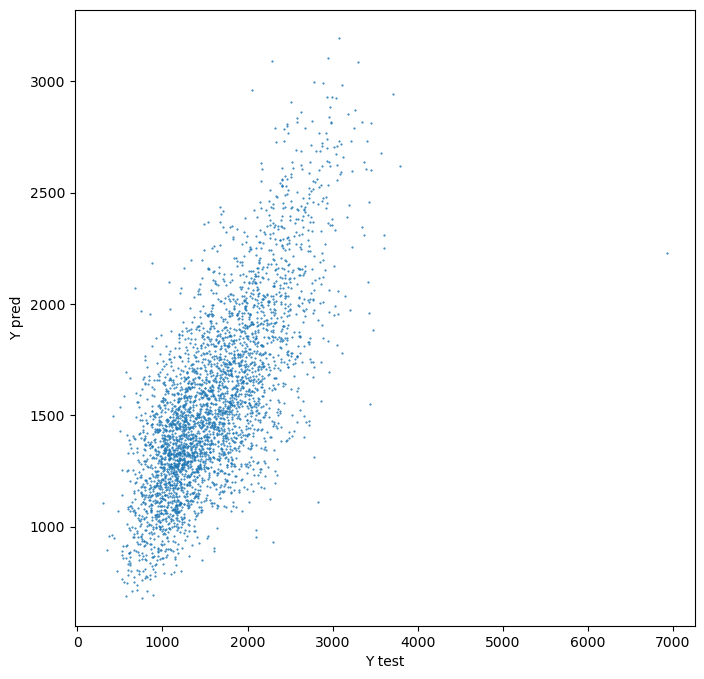

In [17]:
fig, ax = plt.subplots(figsize=(8, 8))
plt.scatter(data.house_price_index[mask], meta["queen5"]["prediction"], s=0.25)
plt.xlabel("Y test")
plt.ylabel("Y pred")

Plot the values using the original cmap.

In [18]:
from shapely.geometry import box

bds = data.total_bounds
extent = gpd.GeoSeries(
    [box((bds[0] - 7000), bds[1], bds[2] + 7000, bds[3])], crs=data.crs
).to_crs(3857)

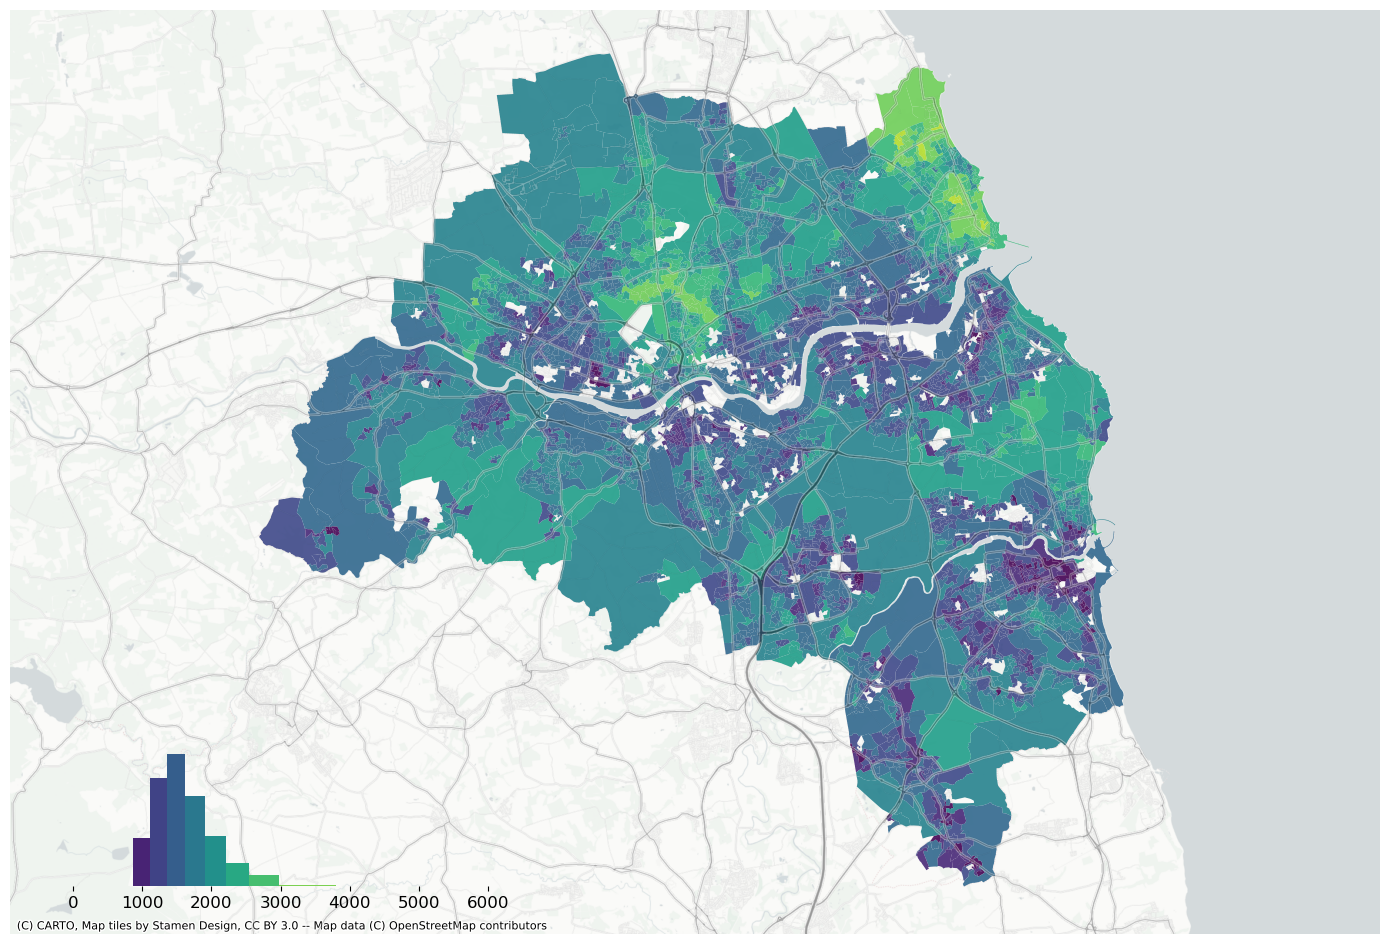

In [23]:
f, ax = plt.subplots(figsize=(18, 12))
extent.plot(ax=ax, alpha=0)
bins = mapclassify.NaturalBreaks(data["house_price_index"].dropna().values, k=10).bins

data.assign(pred=meta["queen5"]["prediction"]).to_crs(3857).plot(
    "pred",
    scheme="userdefined",
    classification_kwds={"bins": bins},
    ax=ax,
    alpha=0.9,
    cmap="viridis",
)
legendgram(
    f,
    ax,
    meta["queen5"]["prediction"],
    bins,
    pal=palmpl.Viridis_10,
    legend_size=(0.35, 0.15),  # legend size in fractions of the axis
    loc="lower left",  # matplotlib-style legend locations
    clip=(
        0,
        data["house_price_index"].max(),
    ),  # clip the displayed range of the histogram
)
ax.set_axis_off()
contextily.add_basemap(
    ax=ax, source=contextily.providers.CartoDB.PositronNoLabels, attribution=""
)
contextily.add_basemap(
    ax=ax,
    source=contextily.providers.Stamen.TonerLines,
    alpha=0.4,
    attribution="(C) CARTO, Map tiles by Stamen Design, CC BY 3.0 -- Map data (C) OpenStreetMap contributors",
)
# plt.savefig(f"{data_folder}/outputs/figures/air_quality_index.png", dpi=150, bbox_inches="tight")

Plot residuals.

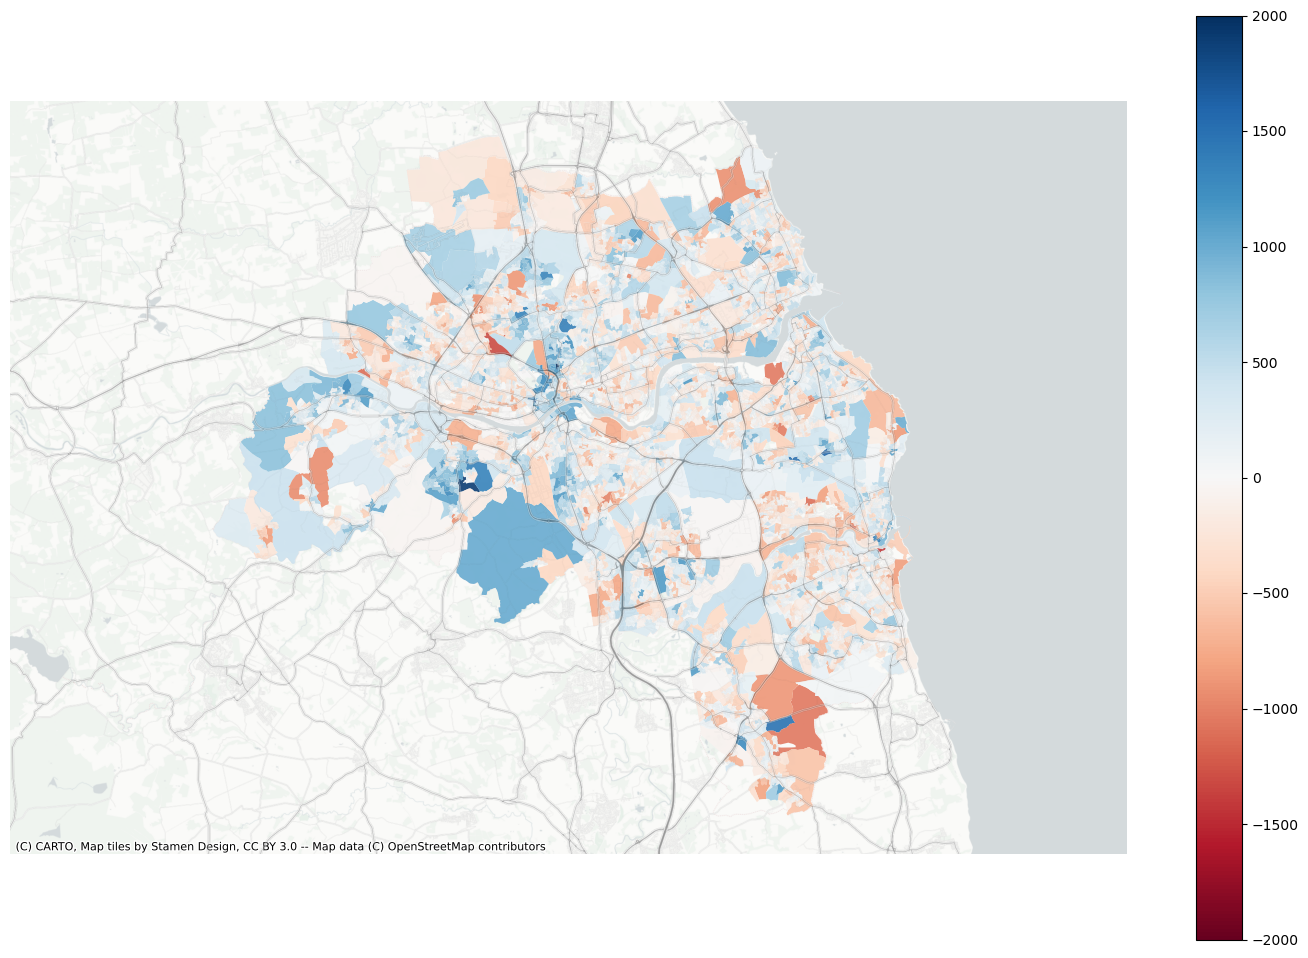

In [20]:
f, ax = plt.subplots(figsize=(18, 12))
extent.plot(ax=ax, alpha=0)
data.assign(res=meta["queen5"]["residuals"]).to_crs(3857).plot(
    "res", ax=ax, alpha=0.9, cmap="RdBu", vmin=-2000, vmax=2000, legend=True
)
ax.set_axis_off()
contextily.add_basemap(
    ax=ax, source=contextily.providers.CartoDB.PositronNoLabels, attribution=""
)
contextily.add_basemap(
    ax=ax,
    source=contextily.providers.Stamen.TonerLines,
    alpha=0.4,
    attribution="(C) CARTO, Map tiles by Stamen Design, CC BY 3.0 -- Map data (C) OpenStreetMap contributors",
)
# plt.savefig(f"{data_folder}/outputs/figures/air_quality_index.png", dpi=150, bbox_inches="tight")

<AxesSubplot: ylabel='Frequency'>

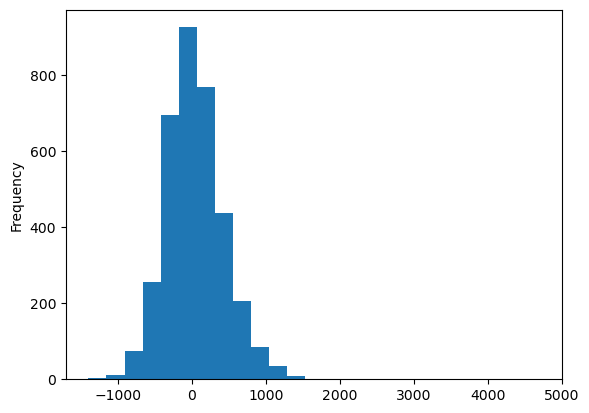

In [21]:
meta["queen5"]["residuals"].plot.hist(bins=25)

There doesn't seem to be any general pattern in where we over- and where underpredict. The general tendency seems to be captured and a comparison against this base model shall work in the final app and scenario building.

We can save the meta dict with all the data. The final model is part of that.

In [2]:
import pickle

In [26]:
with open(f"{data_folder}/models/house_price_meta.pickle", "wb") as f:
    pickle.dump(meta, f)

Save just the model for easy inference.

In [4]:
with open(f"{data_folder}/models/house_price_model.pickle", "wb") as f:
    pickle.dump(meta["queen5"]["model"], f)